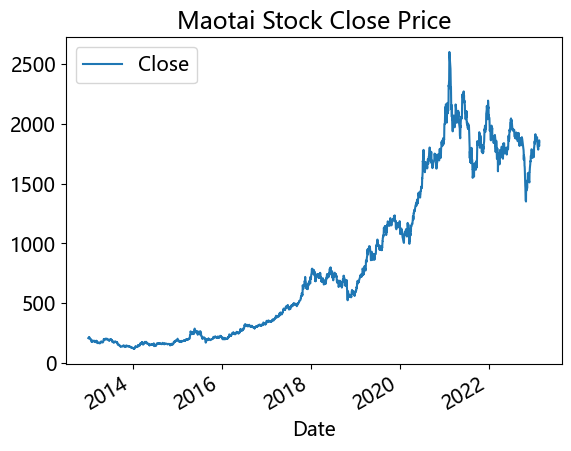

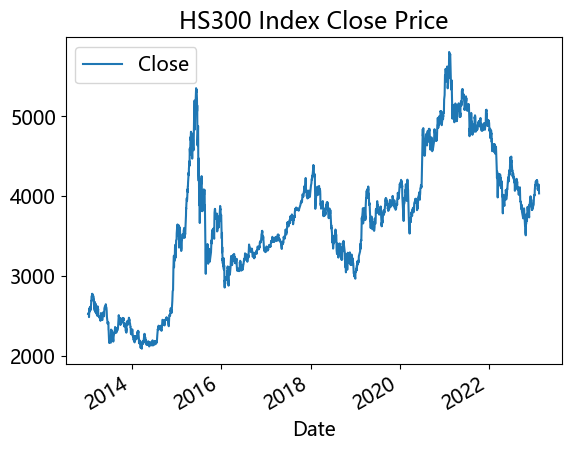

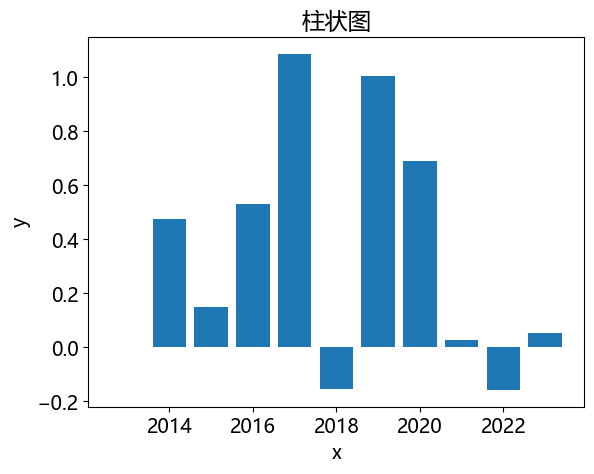

In [34]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm
import sqlite3
import pickle
import matplotlib.pyplot as plt

# Re-extract the SQL data and perform the necessary data cleaning
# Suppose the Maotai stocks closing price data is saved in a DataFrame named "maotai", which columns called "Date" and "Close", and the process of data cleansing has been finished.

# Get data from database and import it into a csv file

database_path = "C:/Users/fortu/mydatabase.sqlite"

# connect to database
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

# Fetch data from table
query_maotai = "SELECT * FROM MAOTAI"
maotai = pd.read_sql_query(query_maotai, conn)

query_hs300 = "SELECT * FROM HS300"
hs300 = pd.read_sql_query(query_hs300, conn)

query_bond10 = "SELECT * FROM BOND10"
bond10 = pd.read_sql_query(query_bond10, conn)

query_credit = "SELECT * FROM CREDIT"
credit = pd.read_sql_query(query_credit, conn)

query_zz500 = "SELECT * FROM ZZ500"
zz500 = pd.read_sql_query(query_zz500, conn)

query_bond3_5 = "SELECT * FROM 'BOND3-5'"
bond3_5 = pd.read_sql_query(query_bond3_5, conn)

# close the connection with database
cursor.close()
conn.close()

# Plot diagram and check whether there were null values or not.
# maotai.plot(x="Date", y="mt_close", title="Maotai Stock Close Price")
# plt.show()

# Delete the line containing missing values
maotai.dropna(inplace=True)
hs300.dropna(inplace=True)
bond3_5.dropna(inplace=True)
bond10.dropna(inplace=True)
zz500.dropna(inplace=True)
credit.dropna(inplace=True)

# Rename the column of DataFrame
maotai.rename(columns={"mt_close": "Close"}, inplace=True)
hs300.rename(columns={"hs300": "Close"}, inplace=True)
bond10.rename(columns={"bond10": "Close"}, inplace=True)
bond3_5.rename(columns={"bond3-5": "Close"}, inplace=True)
credit.rename(columns={"credit": "Close"}, inplace=True)
zz500.rename(columns={"zz500": "Close"}, inplace=True)

# Building a CAPM model for Maotai stocks
# The interest rate on treasury bonds is a one-year interest rate. And the interest rate has been converted from percentage to decimal form

# Replace missing values with Nan, as well as convert STRING type to FLOAT type
maotai["Close"] = maotai["Close"].replace('', float('nan'))
maotai["Close"] = maotai["Close"].astype(float)

hs300["Close"] = hs300["Close"].replace('', float('nan'))
hs300["Close"] = hs300["Close"].astype(float)

bond10["Close"] = bond10["Close"].replace('', float('nan'))
bond10["Close"] = bond10["Close"].astype(float)

bond3_5["Close"] = bond3_5["Close"].replace('', float('nan'))
bond3_5["Close"] = bond3_5["Close"].astype(float)

credit["Close"] = credit["Close"].replace('', float('nan'))
credit["Close"] = credit["Close"].astype(float)

zz500["Close"] = zz500["Close"].replace('', float('nan'))
zz500["Close"] = zz500["Close"].astype(float)

rm = hs300["Close"]
rf = 0.02

# Convert the Date column to datetime format
maotai["Date"] = pd.to_datetime(maotai["Date"])

hs300['Date'] = pd.to_datetime(hs300['Date'])

zz500['Date'] = pd.to_datetime(zz500['Date'])

bond10['Date'] = pd.to_datetime(bond10['Date'])

bond3_5['Date'] = pd.to_datetime(bond3_5['Date'])

credit['Date'] = pd.to_datetime(credit['Date'])

# Plot diagram to see whether there are outliers (null values) or not.
maotai.plot(x="Date", y="Close", title="Maotai Stock Close Price")
hs300.plot(x="Date", y="Close", title="HS300 Index Close Price")
plt.show()

# Attempt to fill in null values with 0
maotai["Close"].fillna(0, inplace=True)
credit["Close"].fillna(0, inplace=True)
bond3_5["Close"].fillna(0, inplace=True)
bond10["Close"].fillna(0, inplace=True)
zz500["Close"].fillna(0, inplace=True)
hs300["Close"].fillna(0, inplace=True)

# Linear interpolation
maotai["Close"].interpolate(method='linear', inplace=True)

# Adjust values other than 3 standard deviations to values of 3 standard deviations
std = maotai["Close"].std()
mean = maotai["Close"].mean()
maotai["Close"] = np.where(maotai["Close"] > mean + 3 * std, mean + 3 * std, maotai["Close"])
maotai["Close"] = np.where(maotai["Close"] < mean - 3 * std, mean - 3 * std, maotai["Close"])

# The z-score value of the data is calculated in a rolling window of 60 data points.
maotai["z-score"] = maotai["Close"].rolling(window=60).apply(lambda x: (x[-1] - x.mean()) / x.std(), raw=True)

# Convert the data into a monthly frequency and calculate the momentum of 12-1
maotai.set_index("Date", inplace=True)
maotai_monthly = maotai.resample("M").last()
maotai_monthly["Momentum"] = (
        maotai_monthly["Close"].pct_change(periods=12) - maotai_monthly["Close"].pct_change(periods=1)).dropna()

# Year-over-year yield
maotai_yearly = maotai.resample("Y").last()
maotai_yearly["Yearly Return"] = maotai_yearly["Close"].pct_change()
maotai_yearly.fillna(0, inplace=True)

x = np.array(maotai_yearly["Yearly Return"].index)
x = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
y = np.array(maotai_yearly["Yearly Return"])
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'#Display Chinese characters",
# plt.rc('font', size=14)
# plt.figure(figsize=(6,4))
# plt.bar(x,y,width = 0.2)
plt.bar(x,y)
plt.title('柱状图')
plt.xlabel('x')
plt.ylabel('y')
# path='D:\\my_python\\ch3\\output\\'
# if not os.path.exists(path):
#   os.makedirs(path)
# plt.savefig(path+'scatter.jpg')
# plt.savefig(path+'plot.jpg')
plt.show()